In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
ls # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import tensorflow as tf
import psutil

print("TensorFlow version",tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
psutil.virtual_memory()

In [ ]:
print (spacy.util.is_package("en_core_web_lg"))

# **Readability Scores + spaCy**

working directory /kaggle/working

spaCy features
xtrain           id url_legal license  \
0  c12129c31       NaN     NaN   
1  85aa80a4c       NaN     NaN   
2  b69ac6792       NaN     NaN   
3  dd1000b26       NaN     NaN   
4  37c1b32fb       NaN     NaN   
5  f9bf357fe       NaN     NaN   
6  eaf8e7355       NaN     NaN   

                                             excerpt    target  standard_error  
0  When the young people returned to the ballroom... -0.340259        0.464009  
1  All through dinner time, Mrs. Fayre was somewh... -0.315372        0.480805  
2  As Roger had predicted, the snow departed as q... -0.580118        0.476676  
3  And outside before the palace a great garden w... -1.054013        0.450007  
4  Once upon a time there were Three Bears who li...  0.247197        0.510845  
5  Hal and Chester found ample time to take an in... -0.861809        0.480936  
6  Hal Paine and Chester Crawford were typical Am... -1.759061        0.476507  

xtrain target 0   -0.

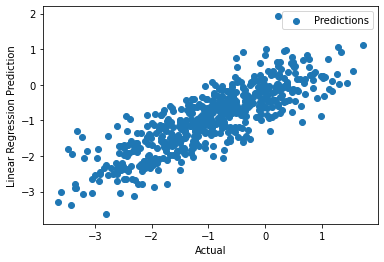

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 16 08:05:43 2021

@author: Jacob
"""
import matplotlib.pyplot as plt
import math
import os

import numpy as np
import pandas as pd 
from pandas import DataFrame

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

import spacy
from transformers import XLNetTokenizer

import sys


print("working directory" , os.getcwd())

useSpaCyParsing = True

print()

if useSpaCyParsing:
    print("spaCy features")
    nlp = spacy.load('en_core_web_lg')



nfolds =  10
 
 
# count syllables: https://stackoverflow.com/questions/46759492/syllable-count-in-python
def syllable_count(word):
    
    count = 0
    vowels = "aeiouy"
    
    if word[0] in vowels:
        count += 1
        
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
            if word.endswith("e"):
                count -= 1
                
    if count == 0:
        count += 1
        
    return count



def punctsPerSentence(text):
    
    doc = nlp(text)
    
    nPuncts = 0 
    nSentences = 0
    
    for sent in doc.sents:
        
        sentence = sent.text.strip()
        
        nSentences += 1
        
        for i in range (0, len (sentence)):   
            #Checks whether given character is a punctuation mark  
            if sentence[i] in ('!', "," ,"\'" ,";" ,"\"", ".", "-" ,"?"):  
                nPuncts += 1 
                  
#    print ("Number of punctuation characters in text: ", nPuncts) 
    
    punctsPerSentence = nPuncts / nSentences
    
    return punctsPerSentence
    

    
xtrain = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
xtest = pd.read_csv('../input/commonlitreadabilityprize/test.csv')


print("xtrain", xtrain.head(7))
print()

print("xtrain target", xtrain.target.head(7))
print()



print("calculating Flesch score")
# Flesch score: https://blog.ung.edu/press/measure-readability/

# count the characters
xtrain['nof_char'] = xtrain['excerpt'].apply(len)
xtest['nof_char'] = xtest['excerpt'].apply(len)

# count the words
xtrain['nof_words'] = xtrain['excerpt'].apply(lambda s: len(s.split(' ')))
xtest['nof_words'] = xtest['excerpt'].apply(lambda s: len(s.split(' ')))

# words to characters
xtrain['w2c'] = xtrain['nof_words'] / xtrain['nof_char']
xtest['w2c'] = xtest['nof_words'] / xtest['nof_char']

# nof sentences
xtrain['nof_sentences'] =  xtrain['excerpt'].apply(lambda s: s.count('.'))
xtest['nof_sentences'] =  xtest['excerpt'].apply(lambda s: s.count('.'))

# nof syllables
xtrain['nof_syllables'] =  xtrain['excerpt'].apply(lambda s: syllable_count(s))
xtest['nof_syllables'] =  xtest['excerpt'].apply(lambda s: syllable_count(s))

# nof punctuation characters per sentence
xtrain['punctsPerSentence'] =  xtrain['excerpt'].apply(lambda s: punctsPerSentence(s))
xtest['punctsPerSentence'] =  xtest['excerpt'].apply(lambda s: punctsPerSentence(s))


# Flesch score
a = 206.835 - 1.015 * (xtrain['nof_words'] / xtrain['nof_sentences'])
b = -84.6 * (xtrain['nof_syllables'] / xtrain['nof_words'])
xtrain['flesch_score'] = a + b

a = 206.835 - 1.015 * (xtest['nof_words'] / xtest['nof_sentences'])
b = -84.6 * (xtest['nof_syllables'] / xtest['nof_words'])
xtest['flesch_score'] = a + b

# Flesch score 2
a = (xtrain['nof_words'] / xtrain['nof_sentences'])
b = (xtrain['nof_syllables'] / xtrain['nof_words'])
xtrain['flesch_score2'] = 0.39 * a + 11.8 * b - 15.59

a = (xtest['nof_words'] / xtest['nof_sentences'])
b = (xtest['nof_syllables'] / xtest['nof_words'])
xtest['flesch_score2'] = 0.39 * a + 11.8 * b - 15.59
 
    
del a,b


print("counting unique words")
# count the unique words
xtrain['nof_unique_words'] = xtrain['excerpt'].apply(lambda s: len(set( s.split(' ') )))
xtest['nof_unique_words'] = xtest['excerpt'].apply(lambda s: len(set( s.split(' ') )))

# text diversity
xtrain['txt_diversity'] = xtrain['nof_unique_words'] / xtrain['nof_words']
xtest['txt_diversity'] = xtest['nof_unique_words'] / xtest['nof_words']

# word lengths
words = xtrain['excerpt'].apply(lambda s: s.split(' '))
word_lengths = words.apply(lambda s: [len(f) for f in s ])
xtrain['longest_word'] = word_lengths.apply(max)
xtrain['avg_word'] = word_lengths.apply(np.mean)

words = xtest['excerpt'].apply(lambda s: s.split(' '))
word_lengths = words.apply(lambda s: [len(f) for f in s ])
xtest['longest_word'] = word_lengths.apply(max)
xtest['avg_word'] = word_lengths.apply(np.mean)

xtrain['txt_diversity'] = xtrain['nof_unique_words'] / xtrain['nof_words']
xtest['txt_diversity'] = xtest['nof_unique_words'] / xtest['nof_words']




nText = 0

for text in xtrain.excerpt:
    
    target = xtrain.target.iloc[nText]

    nText += 1
    
    if nText % 100 == 0:
        print()
        print("--------------------------------------------------------------------------------")
        print("text", nText , text[:77], "target", target)
        print()
    



                    
useSpaCyFeatures = True

if useSpaCyFeatures:
    
    print("getting spaCy features")

    with nlp.disable_pipes():
        train_vectors = np.array([nlp(text).vector for text in xtrain.excerpt])
        test_vectors = np.array([nlp(text).vector for text in xtest.excerpt])
            
    namelist = ['f' + str(ii) for ii in range(train_vectors.shape[1])]
    
    print("namelist" , namelist)
    
    train_vectors = pd.DataFrame(train_vectors)
    test_vectors = pd.DataFrame(test_vectors)
    train_vectors.columns = namelist
    test_vectors.columns = namelist
    
    print("train_vectors" , train_vectors.head())
    
    # combined
    xtrain = pd.concat([xtrain, train_vectors], axis = 1)
    xtest = pd.concat([xtest, test_vectors], axis = 1)

#features = namelist

    features = ['nof_words', 'nof_sentences', 'nof_syllables', 'flesch_score',
            'txt_diversity', 'nof_unique_words', 'nof_char', 'w2c', 
            'flesch_score2', 'punctsPerSentence'] + namelist

else:

    features = ['nof_words', 'nof_sentences', 'nof_syllables', 'flesch_score',
            'txt_diversity', 'nof_unique_words', 'nof_char', 'w2c', 
            'flesch_score2', 'punctsPerSentence'] 

print("xtrain", xtrain.head())
print()

X = xtrain[features].sample(frac=0.8, random_state=0)
# Xtest = xtrain[features].drop(X.index)

y = xtrain['target'].sample(frac=0.8, random_state=0)
# ytest = xtrain['target'].drop(y.index)

Xtest = xtrain[features].iloc[4::5]
ytest =  xtrain['target'].iloc[4::5]

testTexts = xtrain['excerpt'].iloc[4::5]
        
print(len(X), len(Xtest), len(y), len(ytest))

print("X", X.head(7))
print()
print("y", y.head(7))
print()
print("Xtest", Xtest.head(7))
print()
print("ytest", ytest.head(7))
print()
print("testTexts", testTexts.head(7))
print()

   
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, y)

# Make predictions using the testing set
y_pred = regr.predict(Xtest)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(ytest, y_pred))
print('Root Mean squared error: %.10f' % math.sqrt(mean_squared_error(ytest, y_pred)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(ytest, y_pred))
print("sklearn RMSE" ,  np.sqrt(mse(y_pred, ytest)))

def plot_prediction(x, y):
    plt.scatter(x, y, label='Predictions')
#      plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Actual')
    plt.ylabel('Linear Regression Prediction')
    plt.legend()
      
plot_prediction(ytest, y_pred)


print("ytest is a",type(ytest), "    y_pred is a",type(y_pred))


testResults = DataFrame()
testResults['excerpt'] = testTexts 
testResults['predregr'] = y_pred 
testResults['target'] = ytest
#testResults.loc[:,'target'] = ytest

print("testTexts is a",type(testTexts), "    testResults is a",type(testResults))

print(testResults.head(7))

# testResults.to_csv('regression.csv', index = False)

#continuousNN.doMultipleRegression(X , y, Xtest , ytest)

#continuousNN.doMultipleNN(X , y , Xtest , ytest)

Xtest = xtest[features]

y_pred = regr.predict(Xtest)

xsub = xtest[["id"]].copy()
xsub["target"] = y_pred
xsub.to_csv('regression.csv', index = False)






# Transformers XLNet

In [14]:
# -*- coding: utf-8 -*-
"""
Created on Fri May 28 14:00:29 2021

@author: Jacob
"""

from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification

from transformers import XLNetTokenizer
from transformers import TFXLNetForSequenceClassification

# from transformers import AutoModelForSequenceClassification
# from transformers import TrainingArguments
# from transformers import Trainer

import tensorflow_datasets as tfds
import tensorflow as tf

import csv
import os
import sys
import gc

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas import DataFrame

import codecs
import math
from sklearn.metrics import mean_squared_error 


# max_length_text = 7
# batch_size = 100
# number_of_epochs = 1

# max_length_text = 100
# batch_size = 50
# number_of_epochs = 3

max_length_text = 150
batch_size = 10
number_of_epochs = 1

#max_length_text = 300
#batch_size = 1
#number_of_epochs = 1


testScores = []
testData = []

def load_train_validate_lit_data(data_dir):
    """Loads the CommonLit train/validate datasets 
    Input:
    data_dir: path to the "aclImdb" folder.
    
    Returns:
    train/test datasets as pandas dataframes.
    """

    # CommonLit data
    # --------------
    cldata = {}   
    
#    datadir = 'data/CommonLit/'-
    
    text_corpus = []
    targetvals = []
    
    
    with open('../input/commonlitreadabilityprize/train.csv', newline='', encoding='utf8') as trainfile:
#    with open(data_dir + 'train+grades.csv', newline='', encoding='utf8') as trainfile:
        
         corpus = csv.reader(trainfile, delimiter=',', quotechar='"')
         
         for split in ["train", "validate"]:
            
            cldata[split] = []
         
         
         n = 0
         ntest = 0
         
         for row in corpus:
             # print()
             # print(n, row[0])
             # print(row[3])
             if n > 0:
                 
                 text = row[3]
                 score = float(row[4])
                 
                 # if score <= 6:
                 #     score = 0
                 # elif score >= 9:
                 #    score = 1
                 # else:
                 #    continue
                 
                 # if n % 50 == 0:
                 #     cldata["test"].append([text, score])
                 # elif n % 10 == 0:
                 #     cldata["train"].append([text, score]) 

                 if n % 5 == 0:
                      cldata["validate"].append([text, score])
                      
                      if True:   
                        # ntest < 1.4 * 37:
                          testData.append(text)
                          testScores.append(score)
                          ntest += 1
                 else:
 
                     if score < -3.1 :
                         for dup in range(0,10):
                             cldata["train"].append([text, score]) 
                     elif score < -2.6:
                         for dup in range(0,4):
                             cldata["train"].append([text, score]) 
                     elif score < -2.1:
                         for dup in range(0,2):
                             cldata["train"].append([text, score]) 
                     elif score < 0.1:
                         cldata["train"].append([text, score]) 
                     elif score < 0.6:
                         for dup in range(0,2):
                             cldata["train"].append([text, score]) 
                     elif score < 1.2:
                         for dup in range(0,5):
                             cldata["train"].append([text, score]) 
                     else:
                          for dup in range(0,10):
                             cldata["train"].append([text, score]) 

             n += 1
                

    np.random.shuffle(cldata["train"])        
    cldata["train"] = pd.DataFrame(cldata["train"], columns=['text', 'score'])
    #print()
    #print("training data")
    #print(cldata["train"])
    
    np.random.shuffle(cldata["validate"])
    cldata["validate"] = pd.DataFrame(cldata["validate"], columns=['text', 'score'])
    #print()
    #print("validation data")
    #print(cldata["validate"])
    
    return cldata["train"], cldata["validate"]



def load_train_test_imdb_data(data_dir):
    """Loads the IMDB train/test datasets from a folder path.
    Input:
    data_dir: path to the "aclImdb" folder.
    
    Returns:
    train/test datasets as pandas dataframes.
    """

    data = {}
    for split in ["train", "test"]:
        
        data[split] = []
        
        for sentiment in ["neg", "pos"]:
            
            score = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            
            nData = 0
            
            for f_name in file_names:
                
                if nData % 20 == 0:
                    with open(os.path.join(path, f_name), "r", encoding="utf8") as f:
                        review = f.read()
                        data[split].append([review, score])
                    
                nData += 1  
                

    np.random.shuffle(data["train"])        
    data["train"] = pd.DataFrame(data["train"], columns=['text', 'sentiment'])
    print("training data")
    print(data["train"])
    np.random.shuffle(data["test"])
    data["test"] = pd.DataFrame(data["test"], columns=['text', 'sentiment'])
    print("test data")
    print(data["test"])
    
    return data["train"], data["test"]



def convert_example_to_feature(text):
#     # add special tokens
# #    print("text", text)
#     text_with_special_tokens = '[CLS]' + text + '[SEP]'
#     tokenized = tokenizer.tokenize(text_with_special_tokens)
# #    print('tokenized', tokenized)
    
#     # convert tokens to ids in WordPiece
#     input_ids = tokenizer.convert_tokens_to_ids(tokenized)
      
#     # precalculation of pad length, so that we can reuse it later on
#     padding_length = max_length_text - len(input_ids)
    
#     # map tokens to WordPiece dictionary and add pad token for those text shorter than our max length
#     input_ids = input_ids + ([0] * padding_length)
    
#     # attention should focus just on sequence with non padded tokens
#     attention_mask = [1] * len(input_ids)
    
#     # do not focus attention on padded tokens
#     attention_mask = attention_mask + ([0] * padding_length)
    
#     # token types, needed for example for question answering, for our purpose we will just set 0 as we have just one sequence
#     token_type_ids = [0] * max_length_text
#     bert_input = {
#         "input_ids": input_ids,
#         "token_type_ids": token_type_ids,
#         "attention_mask": attention_mask
#         }
        
#     return bert_input

    features = tokenizer.encode_plus(
                        text,                      
                        add_special_tokens = True, # add [CLS], [SEP]
                        max_length = max_length_text, # max length of the text that can go to XLNet
                        pad_to_max_length = True, # add [PAD] tokens
                        return_attention_mask = True, # add attention mask to not focus on pad tokens
              )
 #   print('encoded', bert_input)
 
    return features

try:
    tokenizer = XLNetTokenizer.from_pretrained('../input/xlnet01/hf_xlnet-base-cased', do_lower_case=True)
except Exception as e: # catch *all* exceptions
   print( "Error: " , e)
#tokenizer = BertTokenizer.from_pretrained('uncased_L-12_H-768_A-12', do_lower_case=True)
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#max_length_text = 100
test_sentence = 'Test tokenization sentence. Followed by another sentence'

transformer_input = convert_example_to_feature(test_sentence) 

#print("input")
#print(transformer_input)

# bert_input = tokenizer.encode_plus(
#                         test_sentence,                      
#                         add_special_tokens = True, # add [CLS], [SEP]
#                         max_length = max_length_text, # max length of the text that can go to BERT
#                         pad_to_max_length = True, # add [PAD] tokens
#                         return_attention_mask = True, # add attention mask to not focus on pad tokens
#               )
# print('encoded', bert_input)


train_data, validate_data = load_train_validate_lit_data(data_dir="data/CommonLit/")

test_data = validate_data.head(7)

#train_data, test_data = load_train_test_imdb_data(data_dir="data/aclImdb/")

#print("train_data", train_data)

target = train_data.pop('score')
ds_train = tf.data.Dataset.from_tensor_slices((train_data.values, target.values))

target = validate_data.pop('score')
ds_validate = tf.data.Dataset.from_tensor_slices((validate_data.values, target.values))


# for review, label in tfds.as_numpy(ds_train.take(5)):
#     print('review', review[0:50], label)

# (ds_train, ds_test), ds_info = tfds.load('imdb_reviews', 
#           split = (tfds.Split.TRAIN, tfds.Split.TEST),
#           as_supervised=True,
#           with_info=True)

# print('info', ds_info)

# map to the expected input to TFBertForSequenceClassification, see here 
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    
    return {
              "input_ids": input_ids,
              "token_type_ids": token_type_ids,
              "attention_mask": attention_masks,
           }, label



def encode_examples(ds, limit=-1):
    # prepare list, so that we can build up final TensorFlow dataset from slices.
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    
    if (limit > 0):
        ds = ds.take(limit)
        
    n = 0
    maxNids = 0
    minNids = 1000000
    sumNids = 0
      
    for text, label in tfds.as_numpy(ds):

        transformer_input = convert_example_to_feature(text[0].decode())
        
        nids = len(transformer_input['input_ids'])
        
        sumNids += nids
        
        if nids < minNids:
            minNids = nids
 
        if nids > maxNids:
            maxNids = nids

 #     bert_input = convert_example_to_feature(codecs.decode(review,'ascii'))
        if n % 300 == 0:
            
            print()
            print("******* text",text[0])
            print()
            
            # print("    *** transformer_input",transformer_input)
            print()
            print("nr input ids", len(transformer_input['input_ids']))
#            print(len(transformer_input['input_ids']),"    *** input_ids",transformer_input['input_ids'])
            print()

      
      # if n > 1:
      #     break
        n += 1
    
        input_ids_list.append(transformer_input['input_ids'])
        token_type_ids_list.append(transformer_input['token_type_ids'])
        attention_mask_list.append(transformer_input['attention_mask'])
        label_list.append([label])
   
    meanNids = sumNids / n
    print("minNids", minNids, "meanNids", meanNids, "maxNids", maxNids)    
   
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)



def predict_testdata():
    
    xtest = pd.read_csv('../input/commonlitreadabilityprize/test.csv')
    
    texts = xtest['excerpt']
    
    print("test texts",texts.head)
    
    testResults = DataFrame()
    testResults = xtest[["id"]].copy()
   
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    
    predictedScores = []
    
    n = 0
    
    for text in texts:
        
        n += 1
        
        input_ids_list = []

        transformer_input = convert_example_to_feature(text)

        # if n % 500 == 0:
            
        #     print()
        #     print("******* text ", text)
        #     print("    *** transformer_input",transformer_input)
        #     print(len(transformer_input['input_ids']),"    *** input_ids",transformer_input['input_ids'])
        #     print()

      
      # if n > 1:
      #     break
    
        input_ids_list.append(transformer_input['input_ids'])
      #  token_type_ids_list.append(transformer_input['token_type_ids'])
      #  attention_mask_list.append(transformer_input['attention_mask'])
        
        inp_tok = np.array([inputid for inputid in input_ids_list])
    
        preds = model.predict(inp_tok,  batch_size=1, verbose=False)
        
        predictedScore = preds.logits[0][0]
        
        if n % 10 == 0:
            print("n", n, "predictedScore", predictedScore)
        
        predictedScores.append(predictedScore)
#    preds = model.predict(inp_tok, batch_size=batch_size, verbose=True)
        gc.collect()
    
#    print("texts", texts)
#    print("predictions", preds.logits)

#    predictedScores = []
     
    n = 0
    
    print("prediction done")
    
    testResults['target'] = predictedScores
    
    

    testResults.to_csv('xlnet.csv', index = False)
   

#batch_size = 50


# train dataset
print()

training = True

if training:
    
    print("training dataset")
    ds_train_encoded = encode_examples(ds_train)
    ds_train_encoded_batched = ds_train_encoded.batch(batch_size)
    #ds_train_encoded = encode_examples(ds_train).batch(batch_size)
    #ds_train_encoded = encode_examples(ds_train).shuffle(10000).batch(batch_size)
    # test dataset
    print("validation dataset")
    ds_validate_encoded = encode_examples(ds_validate)
    ds_validate_encoded_batched = ds_validate_encoded.batch(batch_size)
    
#    sys.exit()

    # recommended learning rate for Adam 5e-5, 3e-5, 2e-5
    learning_rate = 2e-5
    # we will do just 1 epoch for illustration, though multiple epochs might be better as long as we will not overfit the model
#    number_of_epochs = 3
    
    # model initialization
#    model = AutoModelForSequenceClassification.from_pretrained('./hf_xlnet-base-cased/', from_tf=True, num_labels=1)
#    model = TFXLNetForSequenceClassification.from_pretrained('./hf_xlnet-base-cased/', num_labels=1)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
    loss = tf.keras.losses.MeanSquaredError()


    step = 0
    
    while step <= 7:
        # Place tensors on the CPU
        with tf.device('/CPU:0'):
            
            newDir = './savedmodel/' + str(step + 1) 
            
            if not os.path.exists(newDir):
                os.makedirs(newDir)
    
            if step == 0:
  #              model = TFXLNetForSequenceClassification.from_pretrained('../input/xlnet01/savedmodel150_2best/', num_labels=1)
                model = TFXLNetForSequenceClassification.from_pretrained('../input/xlnet01/hf_xlnet-base-cased/', num_labels=1)
            else:
                model = TFXLNetForSequenceClassification.from_pretrained('./savedmodel/' + str(step) + '/', num_labels=1)
                
            model.compile(optimizer=optimizer, loss=loss, metrics=[])
        
            print("start training with max_length_text", max_length_text, "batch_size", batch_size, "step", step)
        
            history = model.fit(ds_train_encoded_batched, epochs=number_of_epochs, steps_per_epoch=10, validation_data=ds_validate_encoded_batched)
    
            print("training done step " + str(step))
        
            step += 1
        
            model.save_pretrained('./savedmodel/' + str(step) + '/', saved_model=False)
            
            gc.collect()

else:
    # use saved model for prediction
    with tf.device('/CPU:0'):

        model = TFXLNetForSequenceClassification.from_pretrained('../input/xlnet01/savedmodel150_2best', num_labels=1)
    
        print()
        print("nr of testData", len(testData))
        print()
        for testText in testData[:7]:
            print(testText[:49])
       

        predict_testdata()

        print()




sys.exit()

predictions = model.predict(ds_validate_encoded, verbose = False)
print("type predictions", type(predictions))
print("type predictions.logits", type(predictions.logits))
print("predictions.logits", predictions.logits)
print("len predictions", len(predictions.logits))
#print("tf.argmax(predictions)",  tf.argmax(predictions).numpy())
#print("tf.nn.softmax(predictions, axis=-1)", tf.nn.softmax(predictions.logits, axis=-1))

print()

print("test_data", test_data)

# result = model(ds, training=False)
# result = tf.argmax(result).numpy()
# print(result)



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


All model checkpoint layers were used when initializing TFXLNetForSequenceClassification.

All the layers of TFXLNetForSequenceClassification were initialized from the model checkpoint at ./savedmodel/5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetForSequenceClassification for predictions without further training.



nr of testData 566

Once upon a time there were Three Bears who lived
One day he had gone beyond any point which he had
Aunt Abigail was gone, Eleanor was gone. The room
Father had been away in the country for three or 
One beautiful misummer night in 18— a large, heav
Before Fred could complete the sentence his foot 
When Josie arrived at her destination she went to
n 10 predictedScore -0.6352807
n 20 predictedScore -0.57780975
n 30 predictedScore -2.1973433
n 40 predictedScore 0.3600465
n 50 predictedScore -1.5519806
n 60 predictedScore -0.85689175
n 70 predictedScore -0.09774914
n 80 predictedScore -0.66253567
n 90 predictedScore 0.100836724
n 100 predictedScore -1.6850315
n 110 predictedScore -2.3307252
n 120 predictedScore -1.9078956
n 130 predictedScore -0.14376666
n 140 predictedScore -0.5901213
n 150 predictedScore -1.5638647
n 160 predictedScore -0.7154779
n 170 predictedScore -0.65485036
n 180 predictedScore -0.527873
n 190 predictedScore -2.7968028
n 200 predictedScore -0.9

ValueError: Length of values (566) does not match length of index (7)

<a href="./savedmodel/5/tf_model.h5"> Download Model </a>
<a href="./savedmodel/5/config.json"> Download Config </a>

# Ensemble

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 17 14:37:27 2021

@author: Jacob
"""
import pandas as pd 
from pandas import DataFrame

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.metrics import mean_squared_error 

import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import math
import sys



def sigmoid(x, L , theta, gamma, b):
    
    
    y = L / (1 + np.exp(-gamma * (x - theta))) + b
    
    return (y)


predictionData = pd.read_csv('regression.csv')


resultsXLNet = pd.read_csv('xlnet.csv')

predictionData['predtrsf'] = resultsXLNet['target']

predictionData['avgred'] = (predictionData['target'] + predictionData['predtrsf']) / 2

#y_pred =  predictionData['predtrsf']


print("predictions")

print(predictionData)


# submissiion
xsub = xtest[["id"]].copy()
xsub["target"] = predictionData['avgred']
xsub.to_csv('submission.csv', index = False)

predictions
          id    target  predtrsf    avgred
0  c0f722661 -0.786303 -0.877908 -0.832105
1  f0953f0a5 -0.121382  0.276648  0.077633
2  0df072751 -0.838939 -0.771869 -0.805404
3  04caf4e0c -2.342430 -1.925204 -2.133817
4  0e63f8bea -1.534724 -1.855052 -1.694888
5  12537fe78 -0.725721 -0.330248 -0.527985
6  965e592c0  0.418392  0.393256  0.405824
